# Зависимости

In [ ]:
!pip install pywavelets
!pip install mne
!pip install pywt
!pip install pyedflib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import mne
import pywt
import pyedflib
import pylab
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
from scipy import signal
from scipy.fft import fft, fftfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734981 sha256=1b32488529bfac1cdf14b43d0a2deb1a6a8575c7da5a5c819bb4cc134409ed50
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built pyedflib


# Лабораторная работа № 2 - Формирование датасета

In [3]:
#подключаем (монтируем) к ноутубуку свой гугл-диск

from google.colab import drive
drive.mount('/content/drive')
import os
from os import listdir

#обратите внимание - надо указать путь до своей папки на гугл-диске
os.chdir('/content/drive/MyDrive/Example5')

Mounted at /content/drive


In [ ]:
# Директория для сохранения изображений на Google Диске
output_dir = os.path.join(os.getcwd(), 'wavelet_img')
os.makedirs(output_dir, exist_ok=True)

## Функции для обработки файлов EDF

In [ ]:
# Чтение EDF-файла
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))
        for i in range(n):
            signals[i, :] = f.readSignal(i)
    return signals, signal_labels

In [ ]:
# Функция преобразования сигнала в картинку
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):
    # диапазоны частот ритмов мозга
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    v_max = [240, 120, 40, 30, 20]
    for k in range(len(signal)):
            scales = np.linspace(scale_min[k], scale_max[k], num=25, endpoint=True)
            coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
            frequencies = pywt.scale2frequency(wavelet_core, scales) / dt
            # Создаем кастомную цветовую карту от синего до красного с пределами мощности от 0 до 20
            colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
            ax = plt.subplot(5, 1, k + 1)

            extent = [start_time, end_time, frequencies[-1], frequencies[0]]  # Устанавливаем частоту на вертикальной оси
            # Используем фиксированные пределы vmin=0 и vmax=20
            img = ax.imshow(np.abs(coef), extent=extent, cmap=custom_cmap, aspect='auto', vmin=0, vmax=v_max[k])
            # plt.colorbar(label='Magnitude')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_xlabel('Time (seconds)')
            ax.set_ylim(frequencies[-1], frequencies[0])

            # Сохранение изображения
    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    return output_path

In [ ]:
# Парсинг файла с информацией о приступах в edf
def parse_summary_file(summary_file_path):
    edf_files = []
    with open(summary_file_path, 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            k=0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                    k=num_seizures
                    continue

                if k > 0:
                    if ('Seizure' in line)and('Start Time' in line):
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                        continue

                    if ('Seizure' in line)and('End Time' in line):
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
                        k-=1
                        continue

            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files

In [ ]:
#процедура для фильтрации (выделению) из всего сигнала диапазонов частот
def butter_bandpass_filter(data, fs, plot_signal=False, order=5):
    # Определение диапазонов фильтрации
    lowcut = [1, 4, 8, 14, 30]
    highcut = [4, 8, 14, 20, 50]
    nyquist = 0.5 * fs
    # Список для хранения отфильтрованных сигналов
    filtered_signals = []
    # Фильтрация для каждого диапазона частот
    for i in range(len(lowcut)):
        low = lowcut[i] / nyquist
        high = highcut[i] / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.lfilter(b, a, data)
        filtered_signals.append(filtered_data)
    # Построение спектров
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    for i, filtered_data in enumerate(filtered_signals):
        # Преобразование Фурье
        signal_fft = fft(filtered_data)
        # Амплитуды и частоты
        amplitudes = np.abs(signal_fft) / len(filtered_data)
        frequencies = fftfreq(len(filtered_data), 1 / fs)

        # Отбираем только положительные частоты
        positive_freqs = frequencies > 0
        frequencies = frequencies[positive_freqs]
        amplitudes = amplitudes[positive_freqs]
    return filtered_signals

In [ ]:
# процедура выделения из всего сигнала окна для выгрузки части сионала
def measured(signal,window_size,sampling_time):
    window_size = int(window_size * sampling_time)
    a = 0
    b = window_size
    n = signal.size/window_size
    f_signal = np.copy(signal)
    for i in range(int(n)):
        a = i*window_size
        b = (i+1)*window_size
        f_signal[a:b] = signal[a:b] - np.mean(signal[a:b])
    return f_signal

# процедура осреднения сигнала - убираем постоянную составляющую
def mean_delete(filtered_alpha,window_count,sampling_rate,time,plot_signal=False):
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    leg2 = ["Delta_m", "Theta_m","Alpha_m", "Beta_m","Gamma_m"]
    processed_signals = []
    plt.figure(figsize =(15,7))
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))
    for i in range(5):
        filtered_1 = filtered_alpha[i]
        filtered_2 = measured(filtered_1,window_count,sampling_rate)
        processed_signals.append(filtered_2)
        if plot_signal:
          pylab.subplot (5, 1, i+1)
          plt.plot(time, filtered_1, label = leg[i])
          plt.plot(time, filtered_2, label = leg2[i])
          plt.legend(loc = "best")
          plt.xlim([2310, 2311])

    return processed_signals

## Формирование датасета



Были взяты записи пациентов с 10 по 12

In [ ]:
for spisok in range(9,12,1):
  os.chdir('/content')
  #задаем путь до файла с описание ЭЭГ
  summary_file_path = '/physionet.org/files/chbmit/1.0.0/chb%d/chb%d-summary.txt' % (spisok+1, spisok+1)
  physionet_summary_file_url = 'https:/'+summary_file_path
  #зaкачиваем в ноутбук файл описание ЭЭГ
  !wget -r -c -N --no-parent -np $physionet_summary_file_url
  #распарсиваем записи из файла с описанием ЭЭГ на массив данных
  edf_files_list = parse_summary_file('/content'+summary_file_path)

  sampling_rate = 256
  window_count = 0.5
  flag = 0

  #основной цикл превращения EDF в изображение
  for edf_file in edf_files_list:
    os.chdir('/content')
    edf_directory = '/physionet.org/files/chbmit/1.0.0/chb%d/' % (spisok+1)
    edf_file_link = f"{'https:/'}{edf_directory}{edf_file['file_name']}"
    #загружаем EDF в ноутбук
    !wget -r -c -N -np $edf_file_link

    #записывам сигналы и метки ЭЭГ в переменные
    edf_file_path = f"{'/content'}{edf_directory}{edf_file['file_name']}"
    signals, labels = read_edf(edf_file_path)

    # Если есть приступ, генерируем изображения для 3 временных интервалов
    if len(edf_file['seizure_start']) != 0:
      flag = 1
      seizure_times = [(30, '30_sec_before'), (30, '60_sec_before'), (30, '90_sec_before')]
      number = 1
      for seiz_time in range(len(edf_file['seizure_start'])):
        seizure_st = edf_file['seizure_start'][seiz_time]
        seizure_en = edf_file['seizure_end'][seiz_time]
        for time_offset, time_label in seizure_times:
          time_window_start = seizure_st - time_offset
          time_window_end = seizure_st  # Окно в 30 секунд
          seizure_st = seizure_st- 30
          time_window_start_samples = time_window_start * sampling_rate
          time_window_end_samples = time_window_end * sampling_rate
          signal_s = np.delete(signals, [len(signals)-1], axis=0)
          time = np.arange(time_window_start, time_window_end, 1/sampling_rate)

          # Усреднение сигналов
          avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
          for i in range(len(signals)-1):
            avg_signal += signal_s[i, time_window_start_samples:time_window_end_samples]
          avg_signal /= len(signals)

          # Применение фильтра Баттерворта
          filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
          filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time,plot_signal=False)

          # Определяем директорию и путь для сохранения изображения
          os.chdir('/content/drive/MyDrive/Example5/wavelet_img')
          save_dir = os.path.join(output_dir, 'Seizure')
          os.makedirs(save_dir, exist_ok=True)

          # Сохранение изображения
          image_path = f"{edf_file['file_name']}_{time_label}_{number}_wavelet.png"
          save_wavelet_transform(filtered_mean, image_path, save_dir,
                                            time_window_start, time_window_end, sampling_rate,time_label)
          number+=1
    else:
      # Обработка для записей без приступа (Healthy)
      flag = 0
      #приступов нет, поэтому выбираем любое значение времени для выгрузки ЭЭГ
      #time_window_start = 2300
      time_window_start = int(signals.shape[1]/sampling_rate/2)
      #time_window_end = 2330
      time_label = 30 #ширина окна для выгрузки данных
      time_window_end = time_window_start + time_label

      time_window_start_samples = time_window_start * sampling_rate
      time_window_end_samples = time_window_end * sampling_rate
      signals = np.delete(signals, [len(signals)-1], axis=0)
      time = np.arange(time_window_start, time_window_end, 1/sampling_rate)
      # Усреднение сигналов
      avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
      for i in range(len(signals)-1):
        # Проходим по всем каналам
        avg_signal += signals[i, time_window_start_samples:time_window_end_samples]
        avg_signal /= len(signals)  # Среднее значение по всем каналам

      # Фильр Баттерворта
      filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
      # Удаление среднего скользящим окном
      filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time, plot_signal=False)

      # Определяем директорию и путь для сохранения изображения
      save_dir = os.path.join(output_dir, 'Healthy')
      os.makedirs(save_dir, exist_ok=True)
      image_path = f"{edf_file['file_name']}_{time_label}_wavelet.png"

      # Сохранение изображения
      save_wavelet_transform(filtered_mean, image_path,
                                            save_dir,time_window_start,
                                            time_window_end, sampling_rate,time_label)

In [1]:
import glob

In [2]:
healthy = glob.glob('/content/drive/MyDrive/Example5/wavelet_img/Healthy/*')
seizure = glob.glob('/content/drive/MyDrive/Example5/wavelet_img/Seizure/*')
print('Без приступов: ' + str(len(healthy)))
print('Приступы: ' + str(len(seizure)))

Без приступов: 61
Приступы: 150


In [3]:
# Убираем лишнее (по заданию не менее 50 каждого класса)
seizure = seizure[0:len(healthy)]
len(seizure)

61

In [4]:
# Общий список файлов для датасета (нужно не менее 100)
imgs = healthy + seizure
len(imgs)

122

In [5]:
# Получить класс по папке в пути
def get_id_by_path(path):
  class_name = path.split('/')[-2]
  if class_name == 'Healthy':
    return 0
  else:
    return 1

In [6]:
# Словарь id-class
id2class = {0: 'Healthy', 1: 'Seizure'}
# словарь class-id
class2id = {v: k for k, v in id2class.items()}

In [7]:
from sklearn.model_selection import train_test_split

# Разбиваем на тренировочную и тестовую выборки (для равных условий)
train_paths, val_paths = train_test_split(imgs, test_size=0.2, random_state=42)

# Лабораторная работа № 3 - Построение модели

## Обучение с помощью CNN на Pytorch

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/10 | Train Loss: 1.4908, Train Acc: 0.5361 | Val Loss: 0.6554, Val Acc: 0.6000
Epoch 2/10 | Train Loss: 0.7314, Train Acc: 0.5361 | Val Loss: 0.6205, Val Acc: 0.9200
Epoch 3/10 | Train Loss: 0.5660, Train Acc: 0.8247 | Val Loss: 0.3927, Val Acc: 0.8000
Epoch 4/10 | Train Loss: 0.3249, Train Acc: 0.8660 | Val Loss: 0.8437, Val Acc: 0.4000
Epoch 5/10 | Train Loss: 0.3811, Train Acc: 0.7938 | Val Loss: 0.0754, Val Acc: 1.0000
Epoch 6/10 | Train Loss: 0.6311, Train Acc: 0.6495 | Val Loss: 0.0756, Val Acc: 1.0000
Epoch 7/10 | Train Loss: 0.1165, Train Acc: 0.9794 | Val Loss: 0.1684, Val Acc: 0.8800
Epoch 8/10 | Train Loss: 0.1596, Train Acc: 0.9278 | Val Loss: 0.0941, Val Acc: 0.9600
Epoch 9/10 | Train Loss: 0.1156, Train Acc: 0.9588 | Val Loss: 0.0415, Val Acc: 1.0000
Epoch 10/10 | Train Loss: 0.0246, Train Acc: 1.0000 | Val Loss: 0.0065, Val Acc: 1.0000


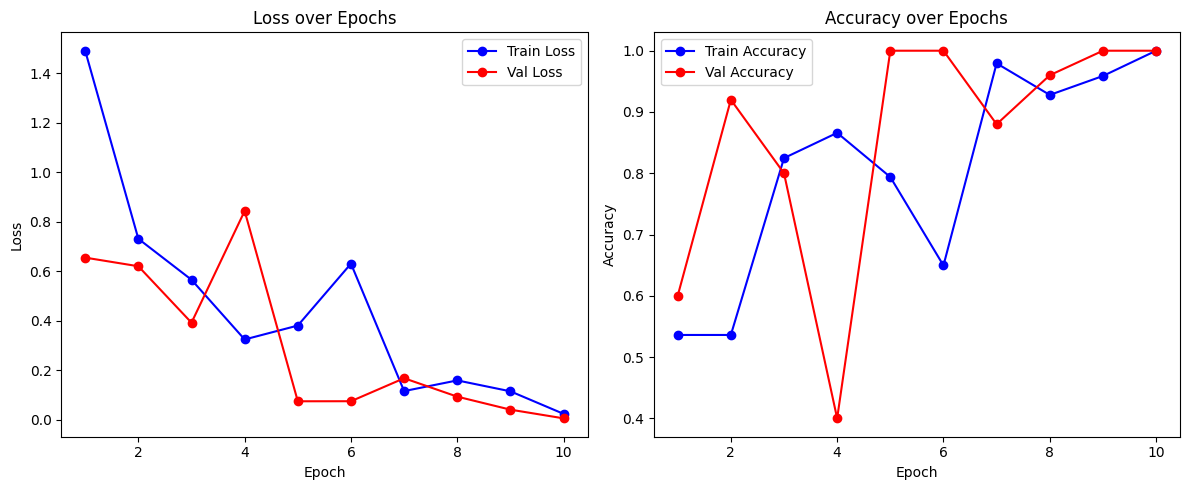

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

torch.manual_seed(42)

# Кастомный Datase
class EEGDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        # Загружаем изображение и переводим его в RGB (если изображение монохромное, дублируем каналы)
        image = Image.open(path).convert('RGB')
        label = get_id_by_path(path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Пример преобразований: меняем размер, переводим в тензор и нормализуем
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_paths, val_paths = train_test_split(imgs, test_size=0.2, random_state=42)

# Создаем объекты Dataset
train_dataset = EEGDataset(train_paths, transform=transform)
val_dataset = EEGDataset(val_paths, transform=transform)

# Создаем DataLoader для батчевой загрузки данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Определяем простую модель сверточной нейронной сети
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Входное изображение имеет 3 канала (RGB)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # При входном размере 128x128, после трёх раз максимального пула получаем размер 16x16
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Выравнивание тензора в вектор
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Настройка устройства: GPU, если доступно, или CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=2).to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)


# Основной цикл обучения
epochs = []       # Список для номера эпох
train_losses = [] # Тренировочные потери
train_accs = []   # Тренировочная точность
val_losses = []   # Валидационные потери
val_accs = []     # Валидационная точность

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Добавляем метрики для эпохи
    epochs.append(epoch + 1)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'ro-', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve, classification_report)

def test_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # для хранения вероятностей положительного класса
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Получаем вероятности через softmax
            probs = torch.softmax(outputs, dim=1)
            # Предсказания
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            # Для ROC и PR curves используем вероятность для класса 1 (Seizure)
            all_probs.extend(probs[:, 1].cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy_val = accuracy_score(all_labels, all_preds)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy_val:.4f}")

    # --- Построение матрицы ошибок ---
    conf_matrix = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[id2class[0], id2class[1]])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # --- Построение ROC-кривой ---
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

    # --- Построение Precision-Recall кривой ---
    precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # --- Вывод полного отчёта по классификации ---
    report = classification_report(all_labels, all_preds, target_names=[id2class[0], id2class[1]])
    print("Classification Report:")
    print(report)

Validation Loss: 0.0065
Validation Accuracy: 1.0000


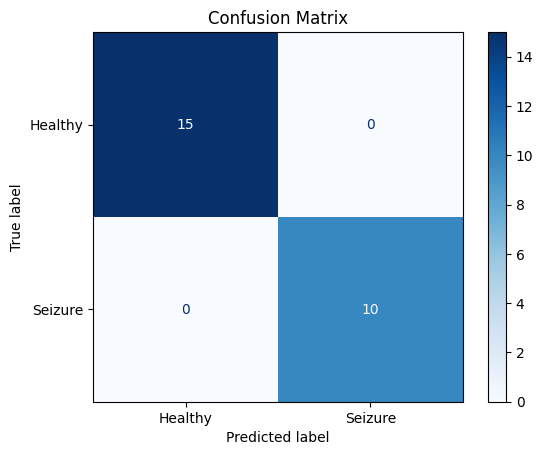

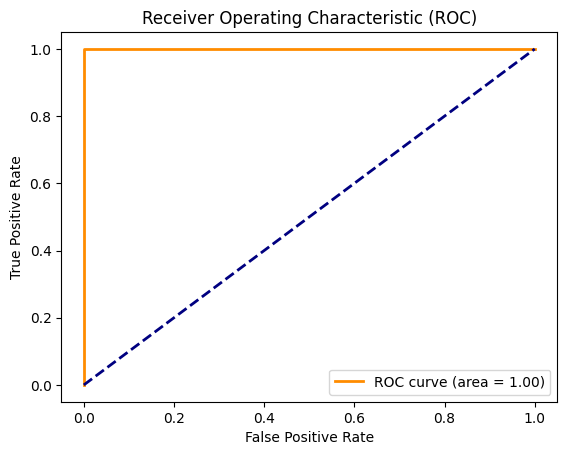

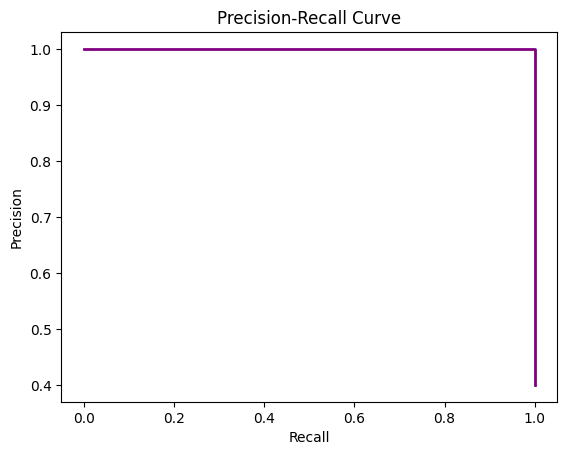

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        15
     Seizure       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [ ]:
test_model(model, val_loader, device)

In [ ]:
torch.save(model, 'model.pth')

## FEDOT

In [ ]:
!python -m pip install pip==24.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install fedot

  Using cached fedot-0.7.5-py3-none-any.whl.metadata (20 kB)
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached thegolem-0.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached anytree-2.12.1-py3-none-any.whl.metadata (8.1 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ete3-3.1.3.tar.gz (4.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached salib-1.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyvis-0.2.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached func_timeout-4.3.5.tar.gz (44 kB)
  Preparing metadata (setup.py) ... done
  Using cached typing-3.7.4.3.tar.gz (78 kB)
  Preparing metadata (setup.py) ... done
  Using cached testfixtures-8.3.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sktime-0.36.1-py3-none-any.whl.metadata (34 kB)
  Using c

Level 100:root:Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


2025-04-07 20:55:00,272 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'


Level 45:root:ApiComposer - Initial pipeline was fitted in 2718.6 sec.


2025-04-07 21:40:23,418 - ApiComposer - Initial pipeline was fitted in 2718.6 sec.


Level 45:root:ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 13593.1 sec.


2025-04-07 21:40:23,428 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 13593.1 sec.


Level 45:root:ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].


2025-04-07 21:40:23,448 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 5 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].


Level 45:root:ApiComposer - Timeout is too small for composing and is skipped because fit_time is 13593.133255 sec.


2025-04-07 21:40:23,677 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 13593.133255 sec.


Level 45:root:ApiComposer - Time for pipeline composing was 0:00:00.
The remaining 40.3 seconds are not enough to tune the hyperparameters.


2025-04-07 21:40:23,698 - ApiComposer - Time for pipeline composing was 0:00:00.
The remaining 40.3 seconds are not enough to tune the hyperparameters.


Level 45:root:ApiComposer - Composed pipeline returned without tuning.


2025-04-07 21:40:23,701 - ApiComposer - Composed pipeline returned without tuning.


Level 45:root:ApiComposer - Model generation finished


2025-04-07 21:40:24,311 - ApiComposer - Model generation finished


Level 45:root:FEDOT logger - Already fitted initial pipeline is used


2025-04-07 21:40:29,219 - FEDOT logger - Already fitted initial pipeline is used


Level 45:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n_jobs': 2, '

2025-04-07 21:40:29,226 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}
logit - {}
catboost - {'n_jobs': 2, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': False, 'allow_writing_files': False, 'use_eval_set': True, 'use_best_model': True, 'enable_categorical': True}
scaling - {}
xgboost - {'n_jobs': 2, 'verbosity': 0, 'booster': 'gbtree', 'tree_method': 'auto', 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30}
lgbm - {'boosting_type': 'gbdt', 'max_depth': -1, 'bagging_fraction': 0.85, 'extra_trees': False, 'enable_categorical': True, 'use_eval_set': True, 'early_stopping_rounds': 30, 'n

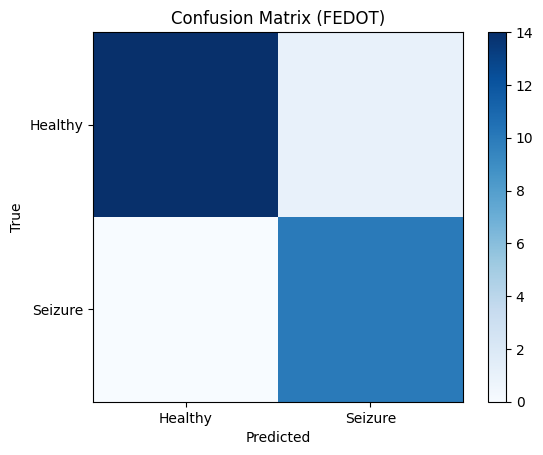

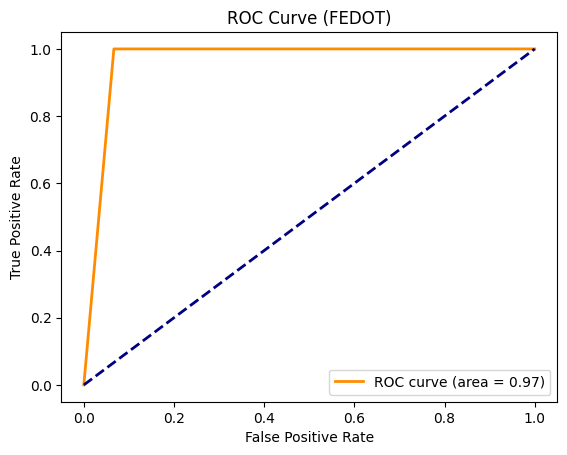

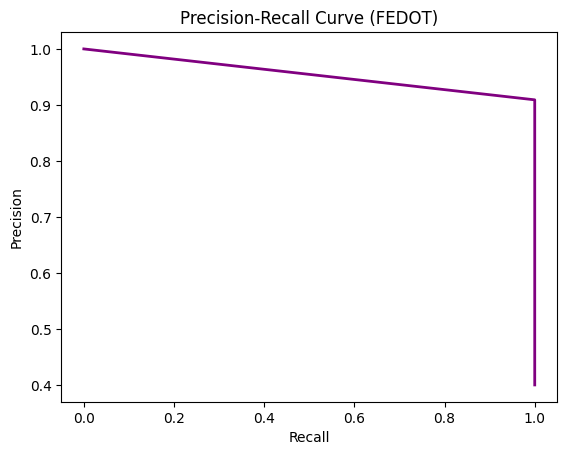

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve)
import matplotlib.pyplot as plt

# Функция для получения метки по пути к изображению
def get_id_by_path(path):
    class_name = path.split(os.sep)[-2]
    return 0 if class_name == 'Healthy' else 1

# Простое извлечение признаков: изменение размера и развёртка в вектор
def load_and_flatten_image(path, size=(128, 128)):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f'Не удалось загрузить изображение: {path}')
    img = cv2.resize(img, size)
    # Нормализуем и разворачиваем в 1D-вектор
    img_flat = img.flatten() / 255.0
    return img_flat

X = []
y = []
for path in imgs:
    X.append(load_and_flatten_image(path))
    y.append(get_id_by_path(path))
X = np.array(X)
y = np.array(y)

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Импортируем FEDOT
from fedot.api.main import Fedot

# Инициализируем AutoML-модель для задачи классификации
automl_model = Fedot(problem='classification', timeout=5,preset='best_quality', n_jobs=4)  # timeout в минутах (или задайте нужное время)
automl_model.fit(features=X_train, target=y_train)
predictions = automl_model.predict(X_test)

print("Отчёт по классификации (FEDOT):")
print(classification_report(y_test, predictions, target_names=['Healthy', 'Seizure']))

# Построим матрицу ошибок
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (FEDOT)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Healthy', 'Seizure'])
plt.yticks(tick_marks, ['Healthy', 'Seizure'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Получаем вероятности для положительного класса
try:
    probs = automl_model.predict_proba(X_test)[:, 1]
except:
    # Если нет, можно сделать softmax от предсказанных "scores"
    probs = predictions

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (FEDOT)")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test, probs)
plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (FEDOT)")
plt.show()

## LAMA

In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 777.6 kB/s eta 0:00:00

Отчет по классификации (LightAutoML):
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        15
     Seizure       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



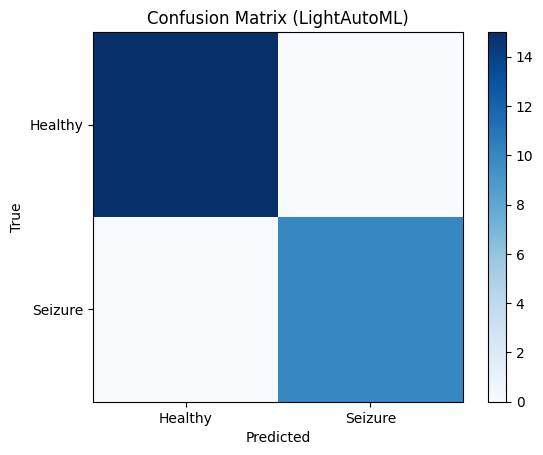

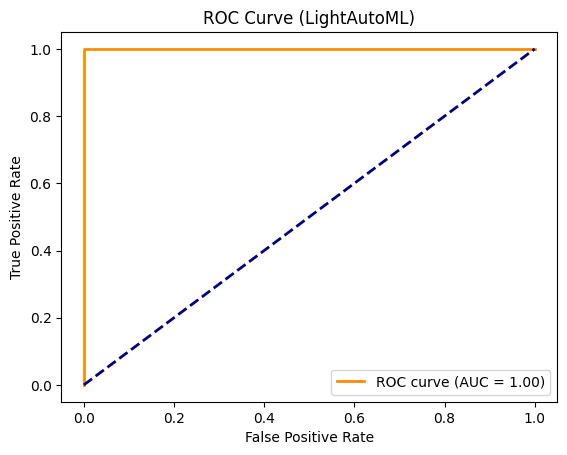

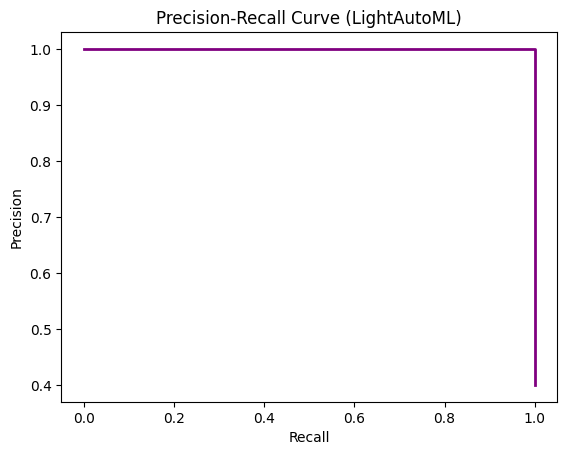

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, classification_report
)
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Функция для получения метки (имени класса) из пути
def get_label_from_path(path):
    # Имя класса считается именем родительской папки
    return os.path.basename(os.path.dirname(path))

# Функция для загрузки и преобразования изображения в вектор признаков
def load_and_flatten_image(path, size=(128, 128)):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {path}")
    img = cv2.resize(img, size)
    # Приводим к типу float32, нормализуем пиксели (0-1) и возвращаем изображение (без разворота вектором)
    # Если требуется вектор, вызовите .flatten() позже
    return img.astype(np.float32) / 255.0


# Извлекаем признаки и метки для каждого изображения
features = []
labels = []
for path in imgs:
    # Загружаем изображение, изменяем размер, нормализуем и превращаем в одномерный вектор
    img_vector = load_and_flatten_image(path, size=(128, 128)).flatten()
    features.append(img_vector)
    labels.append(get_label_from_path(path))

features = np.array(features)
labels = np.array(labels)

# Приводим метки к числовому виду: 'Healthy' -> 0, 'Seizure' -> 1
class_mapping = {'Healthy': 0, 'Seizure': 1}
y = np.array([class_mapping[label] for label in labels])

# Создаем DataFrame с признаками; каждому признаку присваиваем имя feat_0, feat_1, ..., feat_{n-1}
num_features = features.shape[1]
feature_columns = [f'feat_{i}' for i in range(num_features)]
df = pd.DataFrame(features, columns=feature_columns)
df['target'] = y

# Разбиваем данные на обучающую и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Определяем задачу: бинарная классификация
task = Task('binary')

# Создаем AutoML-модель LightAutoML с пресетом для табличных данных
automl = TabularAutoML(task=task, timeout=5)  # timeout задается в минутах

# Важно: явно задаем роли, чтобы указать, что столбец 'target' является целевой
roles = {'target': 'target'}

# Обучаем модель и делаем предсказания
oof_pred = automl.fit_predict(df_train, roles=roles)
test_pred = automl.predict(df_test)

# Извлекаем вероятности для положительного класса (предполагается, что второй столбец содержит их)
probs = probs = test_pred.data[:, 0]

# Получаем бинарные предсказания с порогом 0.5
predictions = (probs > 0.5).astype(int)

# Выводим отчет по классификации
print("Отчет по классификации (LightAutoML):")
print(classification_report(df_test['target'], predictions, target_names=['Healthy', 'Seizure']))

# --- Построение графиков ---

# 1. Матрица ошибок
cm = confusion_matrix(df_test['target'], predictions)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (LightAutoML)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Healthy', 'Seizure'])
plt.yticks(tick_marks, ['Healthy', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 2. ROC-кривая
fpr, tpr, _ = roc_curve(df_test['target'], probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightAutoML)")
plt.legend(loc="lower right")
plt.show()

# 3. Precision-Recall кривая
precision, recall, _ = precision_recall_curve(df_test['target'], probs)
plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LightAutoML)")
plt.show()
